In [1]:
# !pip install openpyxl
import numpy as np
import pandas as pd
import time
import math
from random import randint
import random
import matplotlib.pyplot as plt

#=============================== Let's get data information =================================================

def dataset_info():
    '''this function reads the information about all datas
       and returns informations as a pandas table BKS'''
    
#     #readin excel format file with pandas
#     BKS =  pd.read_excel('BKS.xlsx', sheet_name='BKS')
    
#     #rename the features
#     BKS.rename(columns={'Ins':'file_name', 'n':'Nom_of_node', 'K':'K_min', 'Q':'veh_cap'}, inplace=True)
    
#     # Add '.txt' to file_name values
#     for i in range(30):
#         BKS.loc[i,'file_name'] = BKS.loc[i,'file_name']+str('.txt')

    #Manually
    
    file_name = 'X-n101-k25.txt'
    Nom_of_node = 100
    K_min = 25
    veh_cap = 206
    UB = 27591
    My_dic = {'file_name': file_name, 'Nom_of_node':Nom_of_node , 'K_min': K_min,'veh_cap': veh_cap, 'UB':UB}
    BKS = pd.DataFrame(My_dic, index = list(range(1)))
    return BKS

#================================ reading all text files ========================================================

def get_files(info):
    ''' This function reads all text files and pass them to a dictionary'''
    
    # Reading each file.txt as a table an save all them in a dictionary
    File_Name_dic = {}
    rows= info.index.tolist()
    for row in rows:
        File_Name_dic['data'+str(row)] = pd.read_table(info.loc[row, 'file_name'])
    return rows, File_Name_dic

# ======================== Extracting Tables from each File ====================================================

def get_table(BKS, File_Name_dic,rows):
    ''' Extracts tables from text files and saves them as dictionaries'''
    
    Locations={}
    Demands = {}
    
    # defining some parameters for slicing 
    L_N = 6+BKS['Nom_of_node']
    D_N_L = L_N+2
    D_N_U = D_N_L + BKS['Nom_of_node']
    
    # reading cotumers' location and costumers' demand from each file
    for row in rows:
        Locations['loc'+str(row)] = File_Name_dic['data'+str(row)].loc[6:L_N[row]]
        col2 = str(Locations['loc'+str(row)].columns[1])
        Locations['loc'+str(row)].rename(columns={'NAME : ':'ind',col2:'x','Unnamed: 2':'y'}, inplace=True)
        Locations['loc'+str(row)].set_index('ind', inplace=True)
    
        Demands['dem'+str(row)] = File_Name_dic['data'+str(row)].loc[D_N_L[row]:D_N_U[row]]
        Demands['dem'+str(row)].rename(columns={'NAME : ':'ind',col2:'d'}, inplace=True)
        Demands['dem'+str(row)].set_index('ind', inplace=True)
        Demands['dem'+str(row)].drop('Unnamed: 2',axis=1, inplace=True)
    return Locations, Demands

def coordinates(df, BKS):
    '''return coordinates all points'''
    depo = df.iloc[0,:]
    x_d, y_d = depo[0], depo[1]
    x_c, y_c = df['x'][1:], df['y'][1:]
    return x_d, y_d, x_c, y_c

def comput_cost(D, active):
    '''to compute objective or loss function'''
    Total_cost = 0
    for i,j in active:
        Total_cost +=D[i,j]
    return Total_cost

def active_graph(Rout, cr):
    ''' Gets route and and return active arcs in netwark'''
    
    Y = {(i,j):0 for i,j in cr}  #Binary variable is 1 if vehicle visits client j after visiting client i 
    for key in Rout.keys():
        for i in range(len(Rout[key])):
            if Rout[key][i] == Rout[key][-1]:
                j=0
            else: j = Rout[key][i+1]
            Y[Rout[key][i], j]=1
    active_arcs = [i for i in cr if Y[i]>0]
    return active_arcs, Y

def get_data_information(Instance):
    instance = Instance-1
    data_information = dataset_info()
    rows, Files_name = get_files(data_information)
    Locations, Demands = get_table(data_information, Files_name, rows)
    df = Locations['loc'+str(instance)].astype(float)
    num_of_customer = data_information.loc[instance,'Nom_of_node']
    customer_list = [i for i in range(1,num_of_customer+1 )]
    if instance == 8:gh=0.99
    else: gh=0.97
    all_nodes = [i for i in range(num_of_customer+1)]
    coords = [(i,j) for i in all_nodes for j in all_nodes if i!=j]
    distance = {(i,j): round(math.dist((df['x'][i],df['y'][i]), (df['x'][j],df['y'][j]))*gh) for i,j in coords}
    f_star = data_information.loc[instance, 'UB']
    demand = Demands['dem'+str(instance)]['d'].astype(float)           
    capacity = data_information.loc[instance,'veh_cap']
    K_min = data_information.loc[instance,'K_min']

    parameters = {'data_information':data_information,
                  'location':df,
                  'distance':distance,
                  'num_of_customer':num_of_customer,
                  'customer_list': customer_list,
                  'all_nodes': all_nodes,
                  'coords': coords,
                  'distance': distance,
                  'f_star':f_star,
                  'demand': demand,
                  'capacity': capacity,
                  'K_min': K_min}
    return parameters


def model(beta, q0, rho, alpha, colony, iteration,data_params):
    loc = data_params['location']
    n   = data_params['num_of_customer']
    cl  = data_params['customer_list']
    cr  = data_params['coords']
    fs  = data_params['f_star']
    d   = data_params['demand']
    dis = data_params['distance']
    Q   = data_params['capacity']
    Global = float('inf')
    Gap = []
    Loss=[]
    distance_aray = np.zeros([n+1,n+1])
    eta = np.zeros((n+1,n+1))
    loc = np.asarray(loc)
    for i in range(n+1):
        for j in range(n+1):
            distance_aray[i][j] = np.linalg.norm(loc[i]-loc[j])
    tri_upper = np.triu(distance_aray, k=1)
    for i in range(n+1):
        for j in range(n+1):
            if i < j:
                eta[i][j] = eta[i][j] + 1/tri_upper[i][j]
                eta[j][i] = eta[i][j]  
    tau0 = eta*50
    eta = np.power(eta,beta)
    tau = tau0
    tic = time.time()
    for ITER in range(iteration):
        ant_colony = {}
        for ant in range(colony):
            t_et = np.multiply(tau, eta)
            tet = t_et
            ant_route = {}
            client_visited = []
            index = 0
            u=0
            ant_route[index]=[0]
            r = random.randint(1, n)
            ant_route[index].append(r)
            client_visited.append(r)
            tet[r] = 0
            u = u+d[r]
            while len(client_visited)!=n:
                j = 0
                while j==0:
                    if np.random.uniform()<=q0:
                        j = np.argmax(tet[:,ant_route[index][-1]])
                    else:
                        one_vec = np.ones((1,n+1))
                        col_tot = np.dot(one_vec,tet[:,ant_route[index][-1]])
                        Pij = tet[:,ant_route[index][-1]] / col_tot
                        P_ij = np.cumsum(Pij)
                        chance = np.random.uniform()
                        j = P_ij.searchsorted(chance)
                u = u + d[j]
                if u<=Q:
                    ant_route[index].append(j)
                    client_visited.append(j)
                    tet[j] = 0
                else:
                    index+=1
                    ant_route[index]=[0]
                    u=0
            active,Z = active_graph(ant_route, cr)
            L = comput_cost(dis, active)
            tau = (1-rho)*tau
            ant_colony[L]=ant_route
            for i in range(len(active)):
                x = active[i][0]
                y = active[i][1]
                tau[x][y] = tau[x][y] + alpha*1/L
        bestvalue = min(ant_colony.keys())
        bestroute = ant_colony[bestvalue]
        active_best,Z = active_graph(bestroute, cr)
        for i in range(len(active_best)):
            x = active_best[i][0]
            y = active_best[i][1]
            tau[x][y] = tau[x][y] + alpha*1/bestvalue
        if bestvalue<Global:
            Global = bestvalue
            Best_Route = ant_colony[Global]
        Loss.append(Global)
        gap = round((Global-fs)/fs*100,2)
        print('Best So Far Objective:',Global,' gap: =====',gap)
        Gap.append(gap)
        toc = time.time()
        running_time = round((toc - tic)/60,2)
    return  Global, Best_Route, Gap, Loss, running_time

In [2]:
####################### ACO Algorithm Parameters #######################################
Beta = 2
q_0 = 0.3
Rho = 0.0001
Alpha = 200
Colony = 25
Iteration = 2

In [3]:
Instance = 1
Data_Parameters = get_data_information(Instance=Instance)
BEST_OBJECTIVE, BEST_ROUTE, GAP, LOSS, CPU_TIME = model(Beta, q_0, Rho, Alpha, Colony, Iteration, Data_Parameters)


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


Best So Far Objective: 31656  gap: ===== 14.73
Best So Far Objective: 31656  gap: ===== 14.73


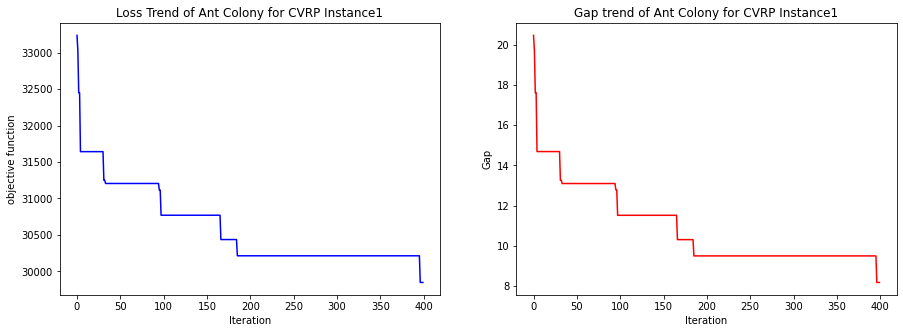

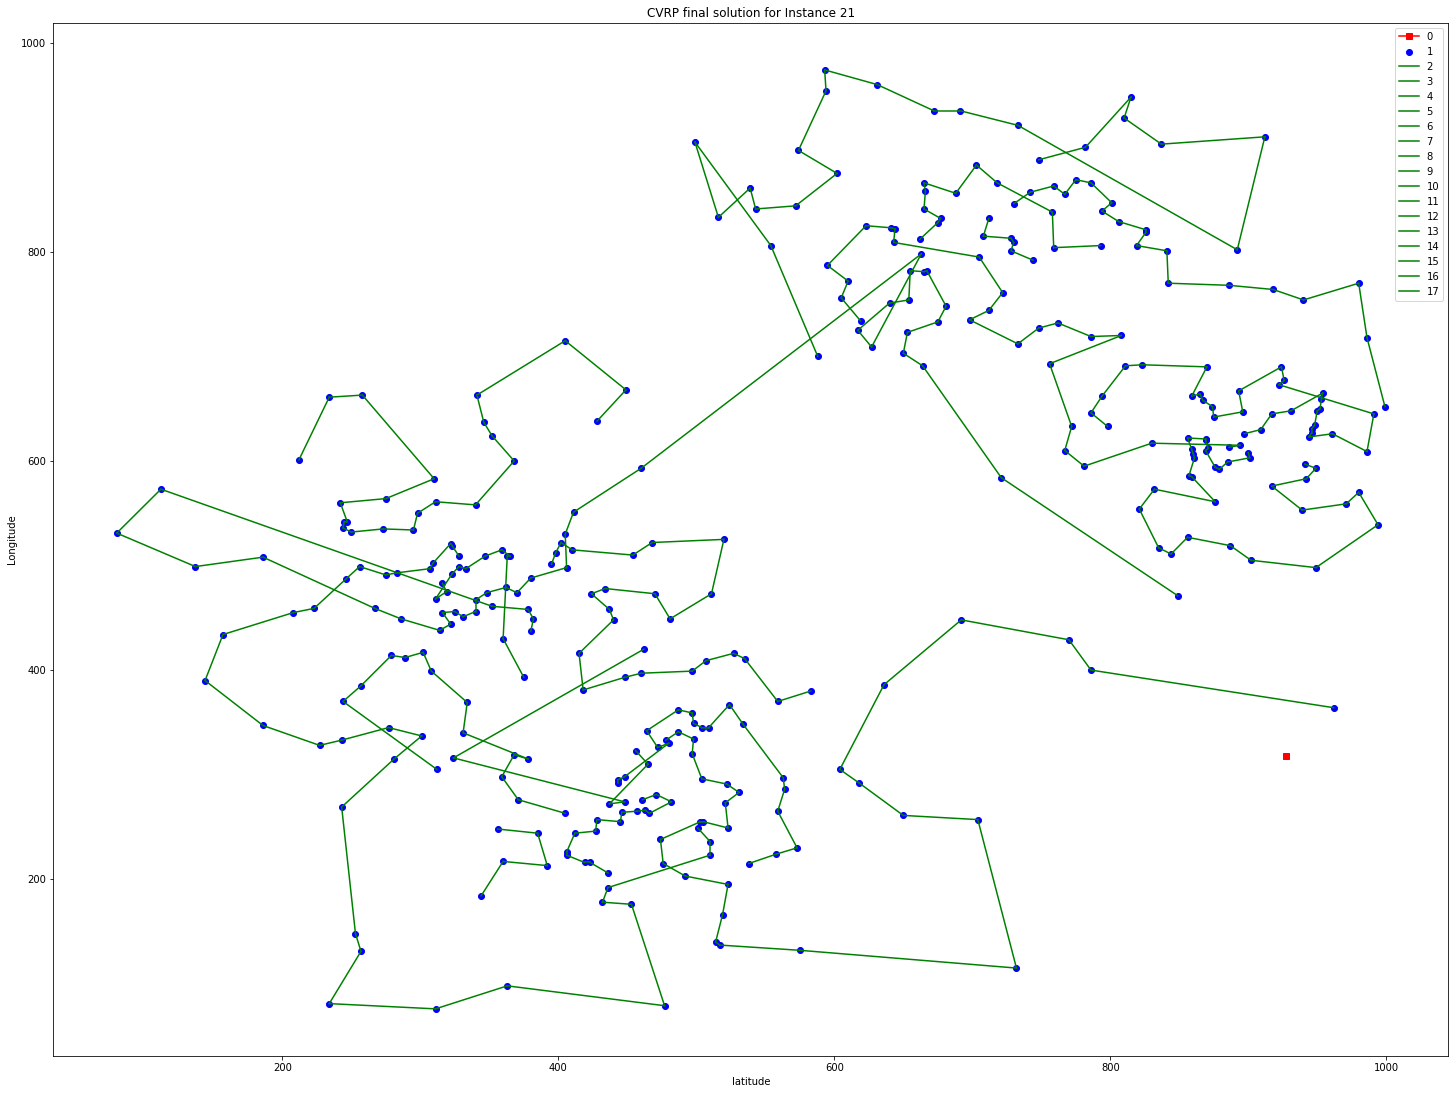

In [131]:
FIG = plt.figure(figsize=(15,5))
ax1 = FIG.add_subplot(121)
ax2 = FIG.add_subplot(122)
ax1.plot(LOSS,'b')
ax2.plot(GAP,'r')


ax1.set_title('Loss Trend of Ant Colony for CVRP'+' Instance'+str(Instance))
ax1.set_ylabel('objective function')
ax1.set_xlabel('Iteration')
ax2.set_title('Gap trend of Ant Colony for CVRP'+' Instance'+str(Instance))
ax2.set_ylabel('Gap')
ax2.set_xlabel('Iteration')
plt.savefig('loss function ACO 1')

comput_cost_counter = Colony*Iteration
with open ('ACO_Instance1-1.txt','w') as f:
    f.write('NO. Of Instance: '+str(Instance)+'\n')
    f.write('Instance Parameters: '+'\n')
    f.write('The Importance of distance (Beta): ' +str(Beta)+'\n')
    f.write('pheromone rate to update the best route in each Iteration(Alpha): '+str(Alpha)+'\n')
    f.write('Evaporation rate(Rho): '+str(Rho)+'\n')
    f.write('Size of colony : '+str(Colony)+'\n')
    f.write('Number of Iteration: '+str(Iteration)+'\n')
    f.write('Best Objective function: ' + str(BEST_OBJECTIVE)+'\n' )
    f.write('Gap: ' + str(min(GAP))+'%'+'\n' )
    f.writelines('CPU Time: '+str(CPU_TIME)+'\n')
    f.write('The total number of times that the objective function is evaluated: '+str(comput_cost_counter)+'\n')

    for row in BEST_ROUTE.keys():
        f.writelines('Route No.'+str(row)+': '+str(BEST_ROUTE[row])+'\n')

data_info = Data_Parameters['data_information']
df  = Data_Parameters['location']
clist  = Data_Parameters['customer_list']
arc  = Data_Parameters['coords']
x_d, y_d, x_c, y_c = coordinates(df, data_info)
arcs = [(i,j) for i in clist for j in clist if i!=j]
graph1, X = active_graph(BEST_ROUTE, arc)
visible_node = [a for a in arcs if X[a]>0]
plt.figure(figsize=(25,19))
ax = plt.subplot(111)
plt.plot(x_d, y_d, 'r',marker ='s')
plt.scatter(x_c, y_c,c='b', marker='o')
k=0
groups = BEST_ROUTE.keys()
for i,j in visible_node:
    plt.plot([df['x'][i], df['x'][j]],[df['y'][i], df['y'][j]],'g')

plt.title("CVRP final solution for Instance 1")
plt.ylabel("Longitude")
plt.xlabel("latitude")
plt.legend(groups)
plt.savefig('problem_ACO 1')